In [ ]:
# default_exp bap_logistic_regression

# bap_logistic_regression

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
from scipy.special import expit as logistic
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

RANDOM_SEED = 123

### The IRIS dataset

In [ ]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
iris.shape

(150, 5)

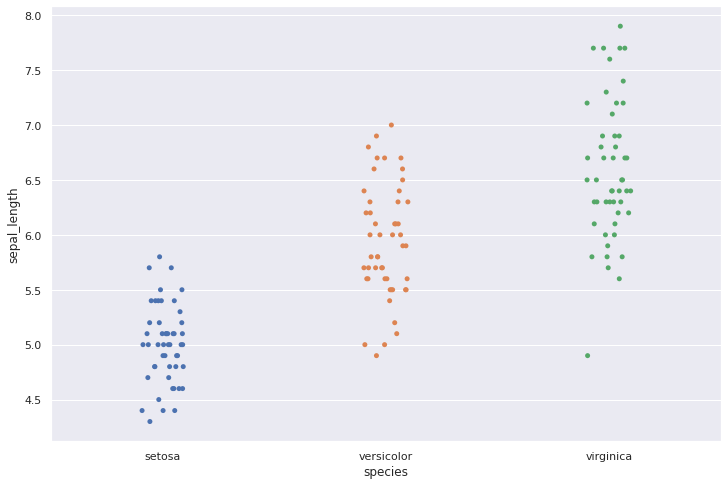

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)

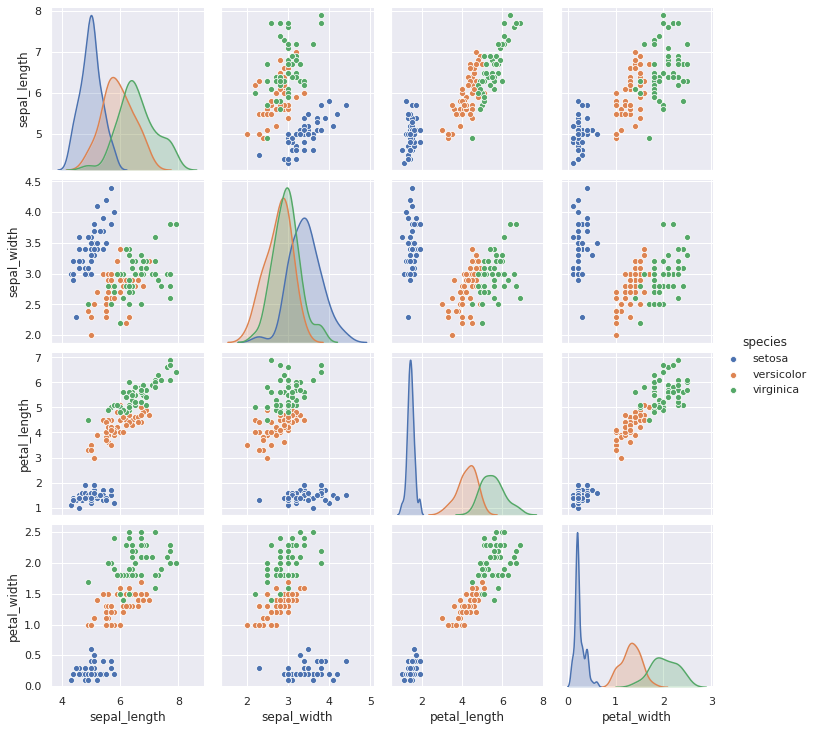

In [ ]:
sns.pairplot(iris, hue='species', diag_kind='kde')

### The logistic model

In [ ]:
# Data preprocessing
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_label = 'sepal_length'
x_0 = df[x_label].values
x_center = x_0 - x_0.mean()

In [ ]:
df.shape

(100, 5)

In [ ]:
# model
with pm.Model() as logit_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    
    μ = α + pm.math.dot(x_center, β)
    #θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    bd = pm.Deterministic('bd', -α/β)
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)
    
    trace_0 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [ ]:
az.summary(trace_0, var_names=['α', 'β', 'bd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.302,0.328,-0.292,0.931,0.005,0.003,5310.0,4742.0,5317.0,5034.0,1.0
β,5.380,1.046,3.503,7.344,0.014,0.010,5691.0,5441.0,5847.0,4993.0,1.0
bd,-0.055,0.061,-0.168,0.059,0.001,0.001,5219.0,5019.0,5224.0,5199.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbecdf7eb90>,
      dtype=object)

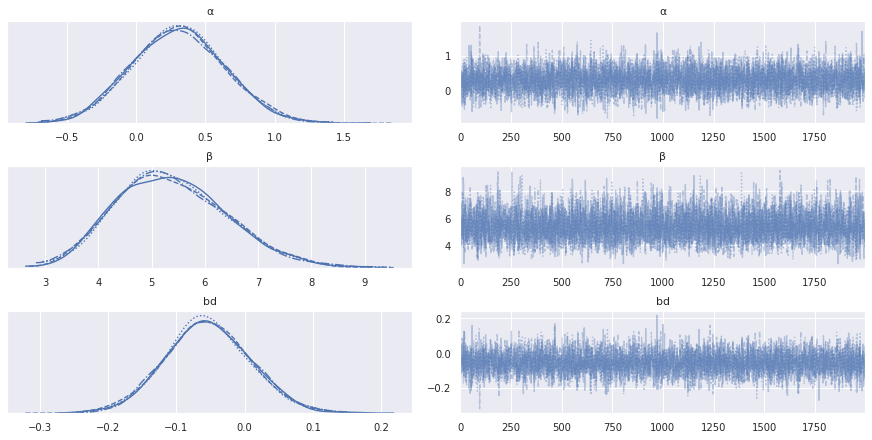

In [ ]:
pm.traceplot(trace_0, ['α', 'β', 'bd'])

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/opt/conda/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (8000) than draws (100). Passed array should have shape (chains, draws, *shape)
  UserWarning,


([<matplotlib.axis.XTick at 0x7fbeb5902850>,
 [Text(0, 0, '4.0'),
  Text(0, 0, '4.5'),
  Text(0, 0, '5.0'),
  Text(0, 0, '5.5'),
  Text(0, 0, '6.0'),
  Text(0, 0, '6.5'),
  Text(0, 0, '7.0'),
  Text(0, 0, '7.5')])

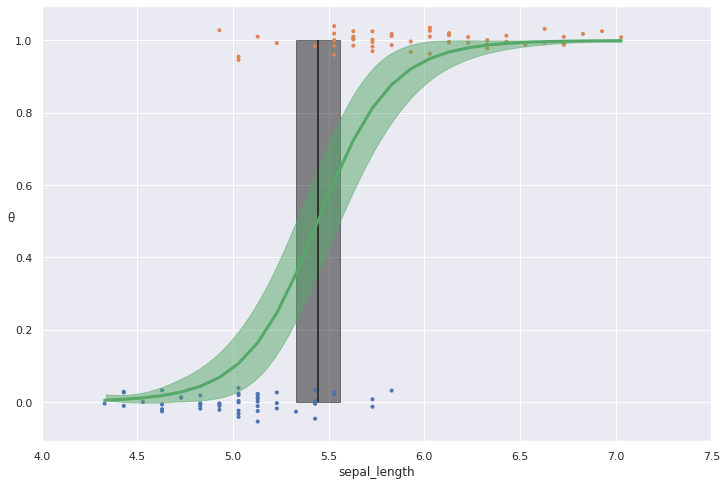

In [ ]:
# Visual posterior dist and observed data
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_center)
plt.plot(x_center[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_center, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hpd(x_center, trace_0['θ'], color='C2')

plt.xlabel(x_label)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))

### Prediction

In [ ]:
def classify(n, threshold):
    n = np.array(n)
    mu = trace_0['α'].mean() + trace_0['β'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob > threshold

In [ ]:
# Test
classify([5, 5.5, 6], 0.4)

(array([1., 1., 1.]), array([ True,  True,  True]))

In [ ]:
y_prob, y_pred = classify(x_center, 0.5)

In [ ]:
accuracy = (y_pred == (y_0 == 1)).mean()
accuracy

0.89